### Project Overview

This project addresses a supervised learning problem, specifically a binary classification task. The goal is to predict whether an individual has heart disease (`HeartDisease`: 1) or not (`HeartDisease`: 0) based on various clinical and lifestyle features. In this project, several classification models are trained and evaluated to identify the best-performing model. The goal is to learn how machine learning techniques can be applied effectively to real-world healthcare datasets for predictive modeling.

### Importing Libraries
Importing all necessary libraries for data processing, visualization, and machine learning.
If a library is missing, it will be automatically installed.

In [2]:
# Install and import required libraries
try:
    import kagglehub
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import os
    import warnings
    warnings.filterwarnings("ignore")
    warnings.filterwarnings("ignore", category=UserWarning, module='tqdm')

    from sklearn.model_selection import train_test_split, GridSearchCV
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,roc_curve, auc
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
    from sklearn.preprocessing import StandardScaler
    from sklearn.svm import SVC
    
except ImportError:
    # Install missing packages
    %pip install kagglehub pandas numpy matplotlib seaborn scikit-learn



### Downloads, locates, and loads the dataset for analysis.

In [3]:
# Download the latest version of the dataset from KaggleHub
path = kagglehub.dataset_download("fedesoriano/heart-failure-prediction")

file_name = "heart.csv"
path_to_file = os.path.join(path, file_name)

# Load the dataset into a pandas DataFrame
df = pd.read_csv(path_to_file)

# Display the first few rows of the dataset
df.head()



,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


### Dataset Overview
This section checks for missing values, examines the data types of each column, displays the dataset’s dimensions, and analyzes the distribution of the target variable, HeartDisease.

In [4]:
# Check for missing values
print(f'Missing Values:\n{df.isnull().sum()}')
# Check the data types of the columns
print(f'Data Types:\n{df.dtypes}')
# Check the shape of the dataset
print(f'Dataset Shape: {df.shape}')
# Check the distribution of the target variable
print(f'Target Variable Distribution:\n{df["HeartDisease"].value_counts(normalize=True)}')


Missing Values:
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64
Data Types:
Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object
Dataset Shape: (918, 12)
Target Variable Distribution:
HeartDisease
1    0.553377
0    0.446623
Name: proportion, dtype: float64


The exploratory data analysis focuses on understanding feature distributions, detecting potential relationships between variables, and evaluating the balance of the target classes.

### Target Variable Visualization
This section creates a bar plot to visualize the distribution of the target variable, HeartDisease, helping to assess class balance in the dataset.

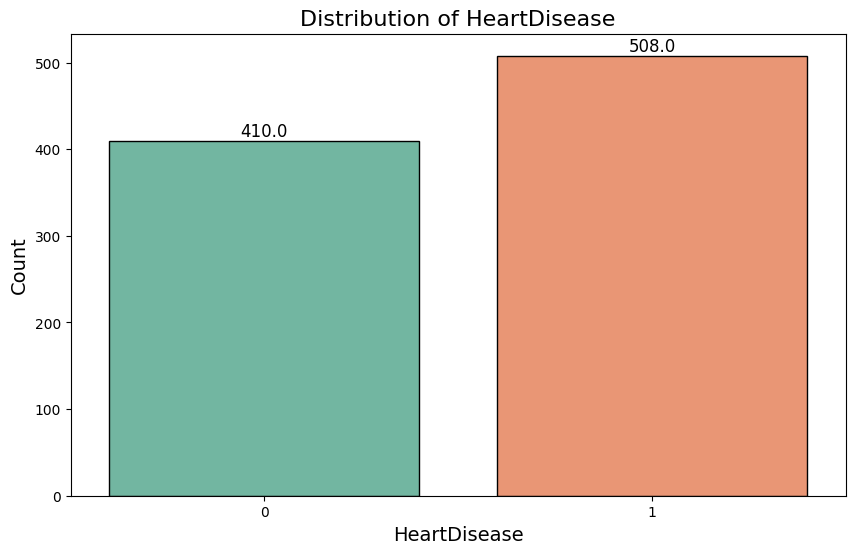

In [5]:
# Visualize the distribution of the target variable 'HeartDisease'

plt.figure(figsize=(10, 6))  
ax = sns.countplot(x='HeartDisease', data=df, palette='Set2', edgecolor='black')

# Add the counts on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=12)

ax.set_title('Distribution of HeartDisease', fontsize=16)
ax.set_xlabel('HeartDisease', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
plt.show()


### Correlation Analysis
Visualizes the correlation matrix to identify relationships between variables.

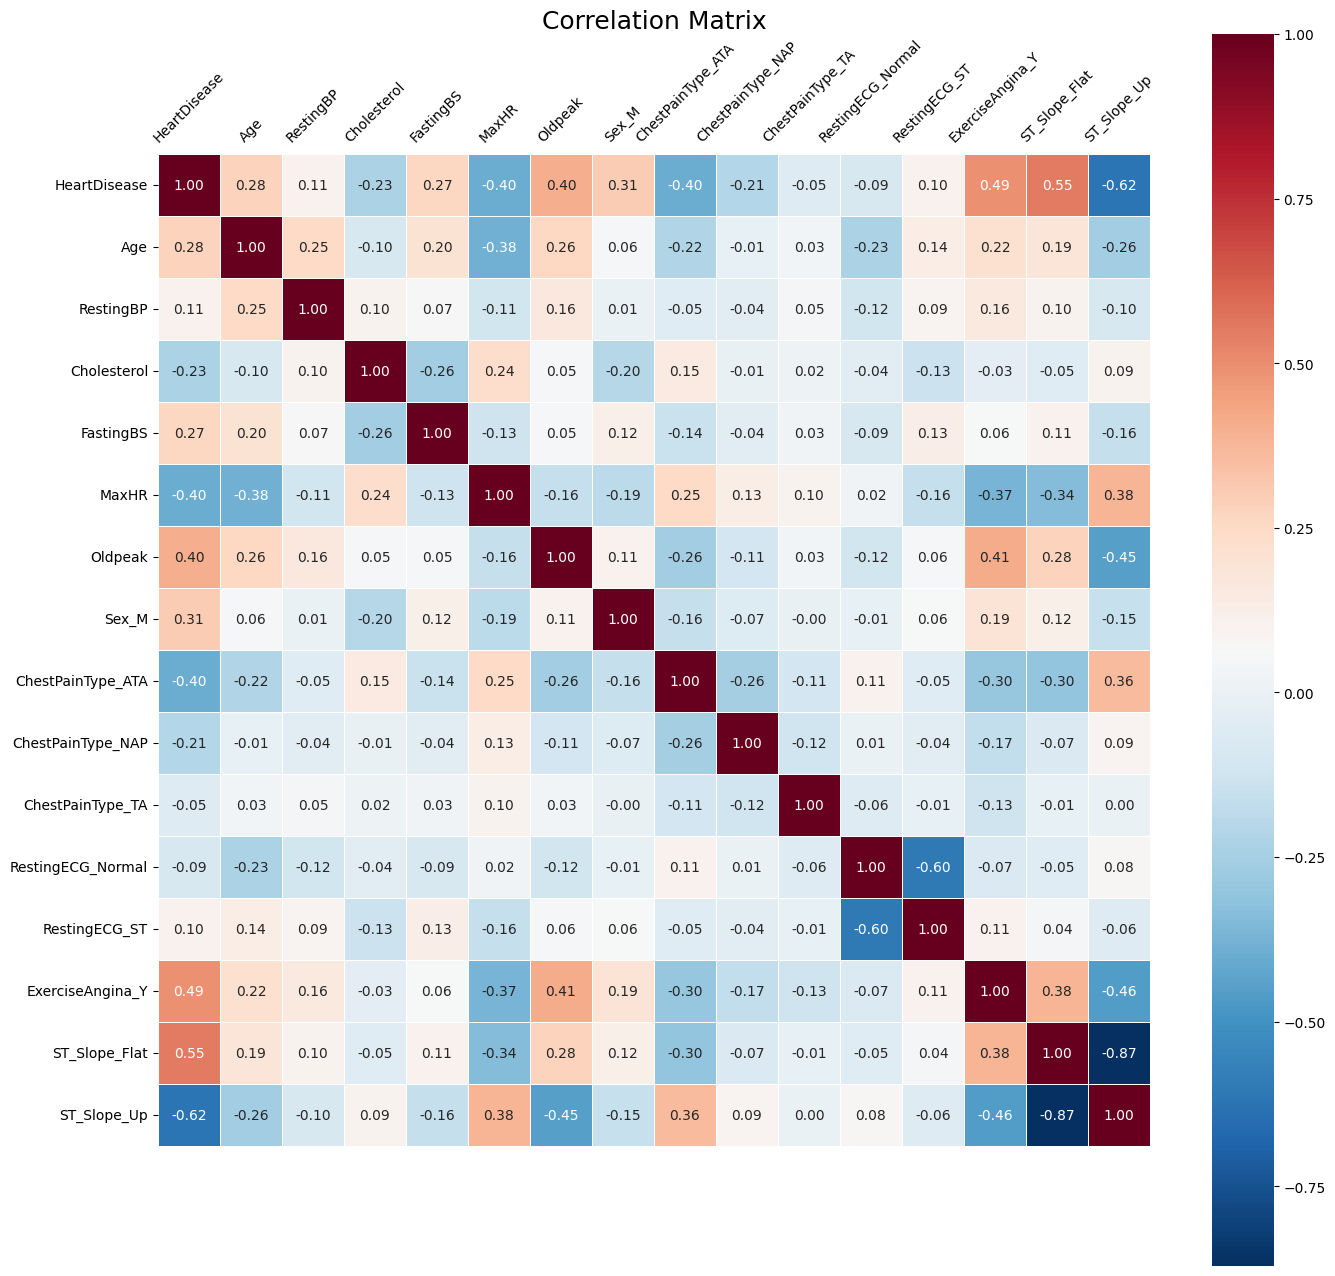

In [6]:
# Encode non-numeric (categorical) columns using one-hot encoding
encoded_df = pd.get_dummies(df, drop_first=True)

# Reorder columns to place 'HeartDisease' first
columns = ['HeartDisease'] + [col for col in encoded_df.columns if col != 'HeartDisease']
reordered_df = encoded_df[columns]

# Visualize the correlation matrix
plt.figure(figsize=(16, 16))
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom=False, bottom=False, top=False, labeltop=True)
corr_heat = sns.heatmap(reordered_df.corr(), annot=True, cmap="RdBu_r", fmt=".2f", linewidths=0.5, cbar=True, square=True)
corr_heat.xaxis.set_tick_params(rotation=45)
plt.title('Correlation Matrix', fontsize=18)
plt.show()

The correlation plot provides a visual summary of the relationships between all features in the dataset.  In particular, features such as ST_Slope_Flat, Oldpeak, and ExerciseAngina_Y show strong correlations with the target variable, HeartDisease, suggesting they may be important predictors. The plot also helps identify any multicollinearity between independent variables that may need to be addressed during modeling.  No immediate feature removal was performed based on correlation.

### Pairplot of Features vs HeartDisease
Generating a pairplot to visualize the relationships between all features and the target variable, HeartDisease.

<Figure size 2500x2500 with 0 Axes>

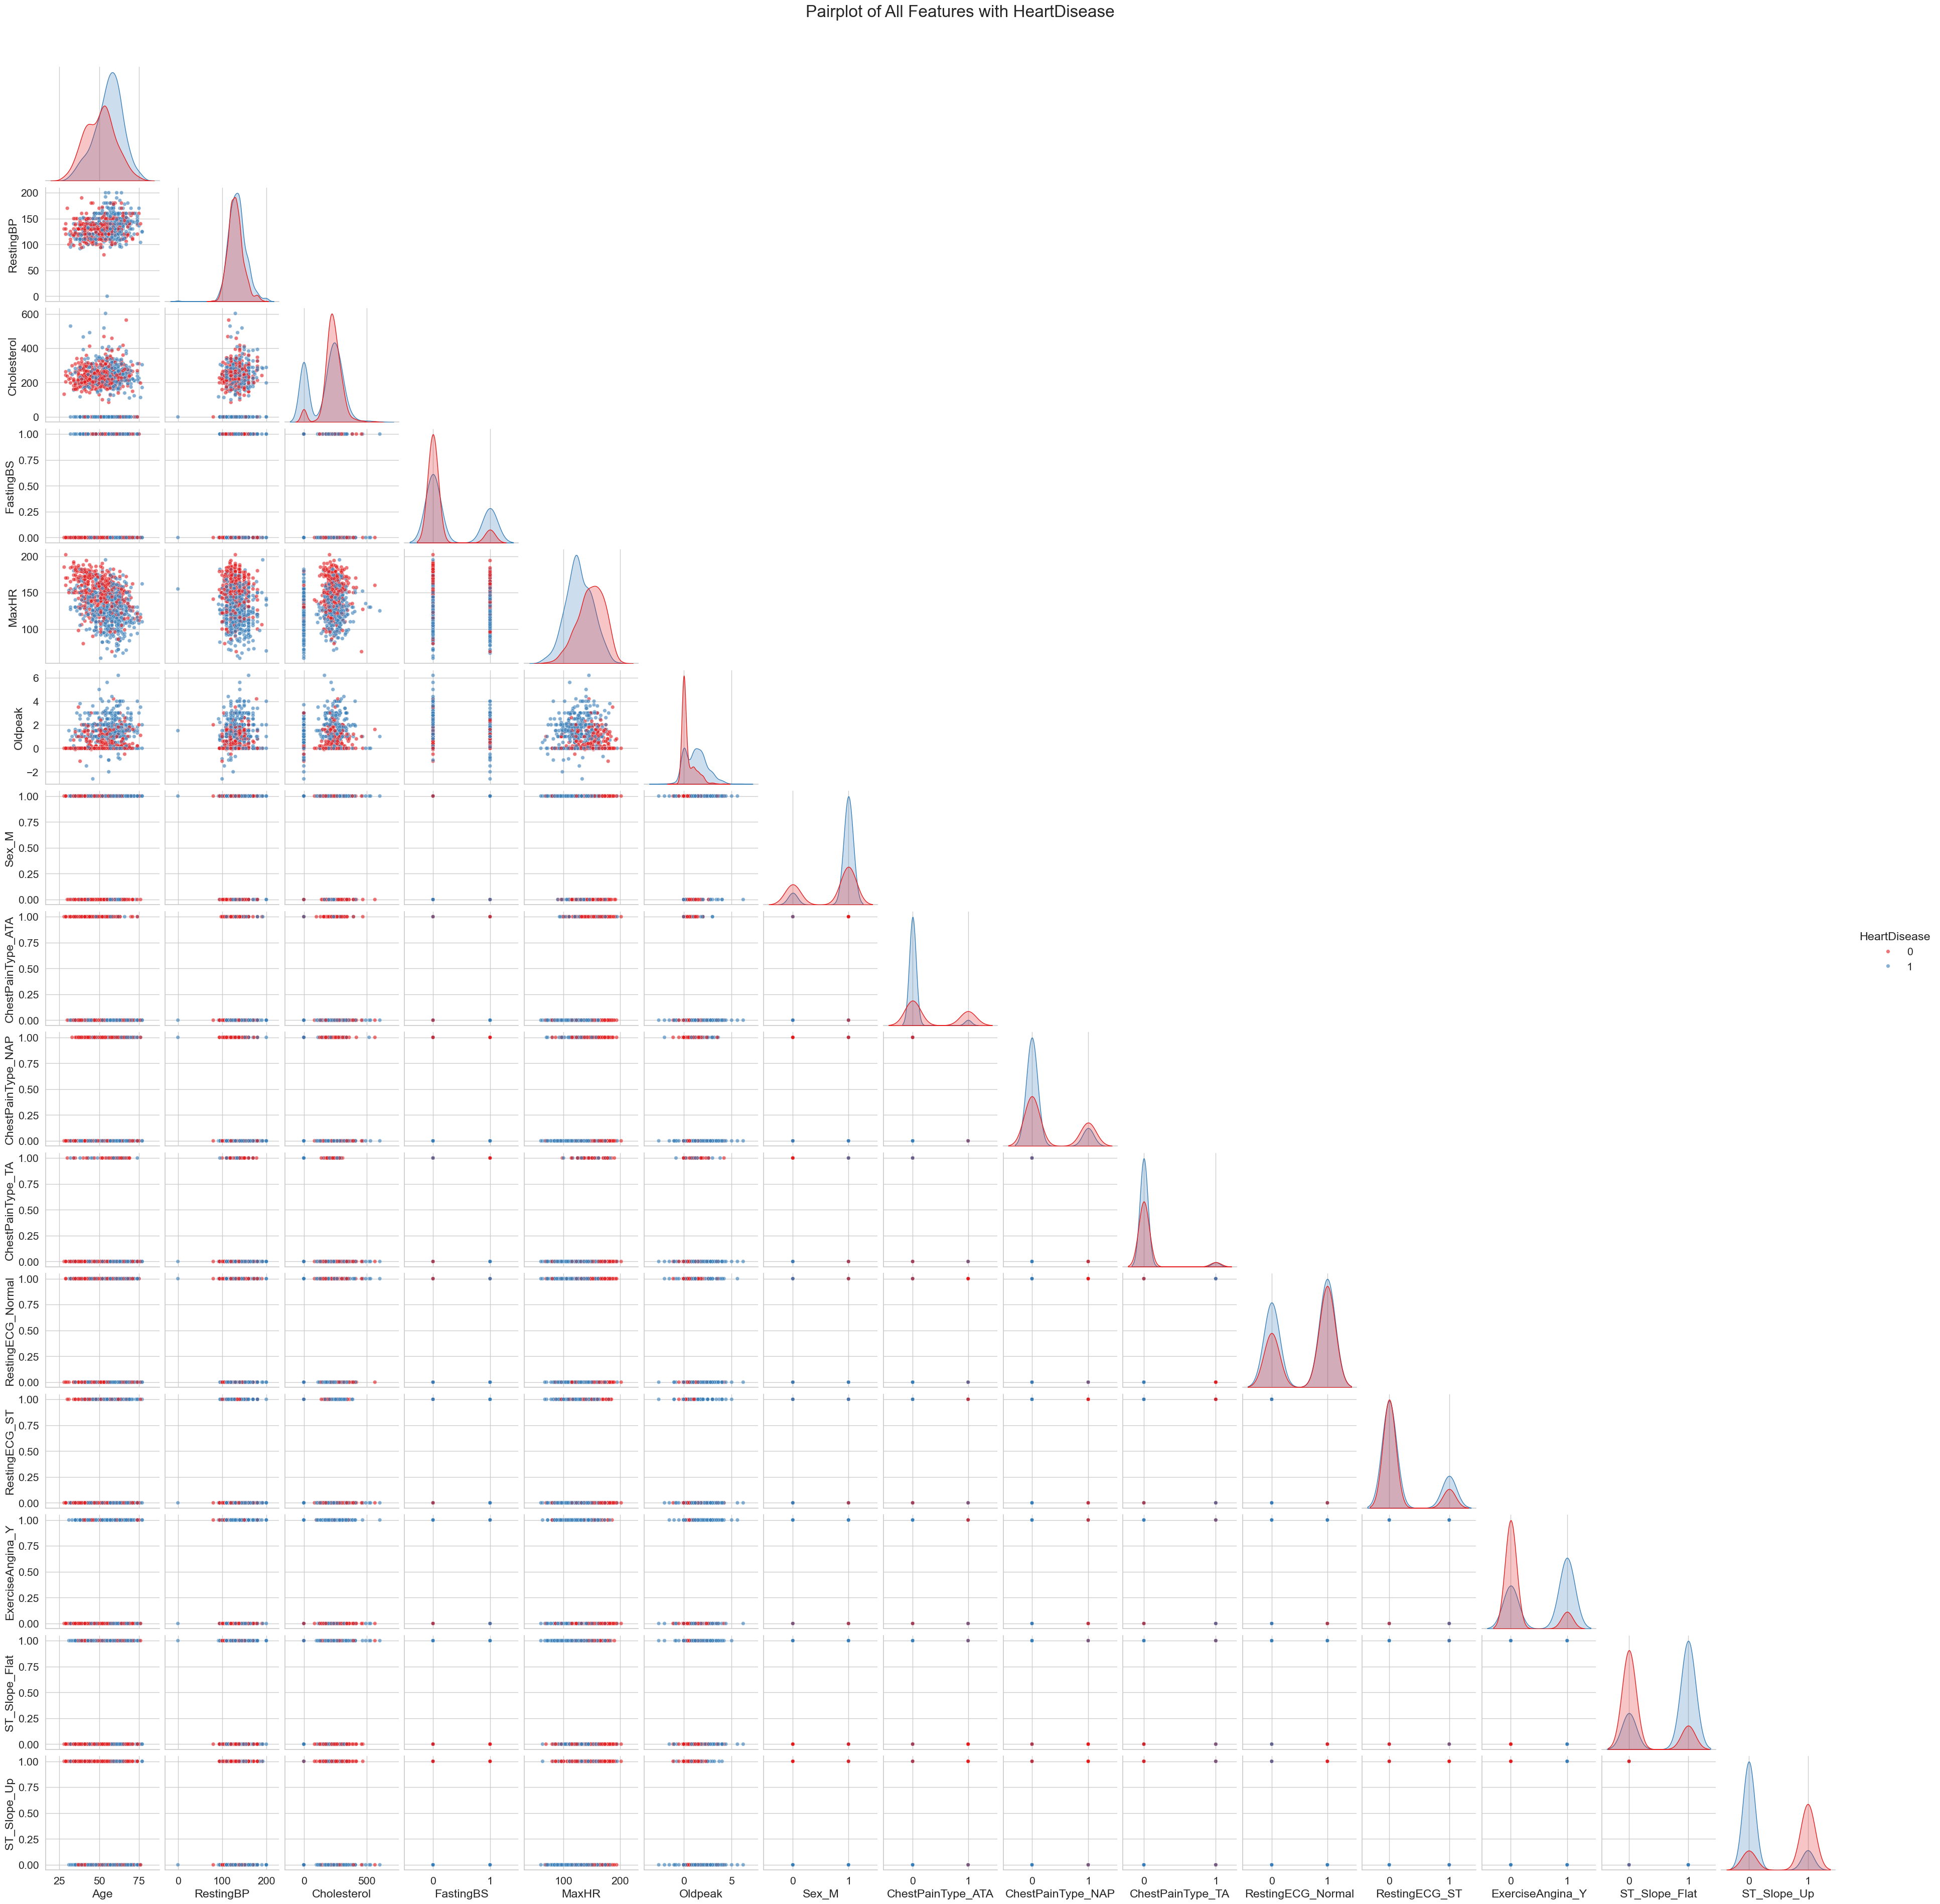

In [7]:
# pairplot of features with HeartDisease to visualize the relationships
sns.set(style='whitegrid', font_scale=1.4)
plt.figure(figsize=(25, 25))
pair_plot = sns.pairplot(reordered_df, diag_kind='kde', hue='HeartDisease', palette='Set1',plot_kws={'alpha': 0.6, 's': 30},corner=True )
pair_plot.fig.suptitle('Pairplot of All Features with HeartDisease', y=1.02, fontsize=24)
plt.show()

The pairplot shows clear differences between individuals with and without heart disease. Those with heart disease typically have lower MaxHR, higher Oldpeak values, more frequent exercise-induced angina, and are more likely to show a flat ST segment slope. Healthy individuals tend to reach higher maximum heart rates and show an upsloping ST segment. Chest pain type (ATA) also differs slightly between groups. In contrast, features like RestingBP, Cholesterol, and FastingBS show little visual separation. Overall, MaxHR, Oldpeak, ST segment characteristics, and ExerciseAngina_Y appear to be the strongest indicators of heart disease.

### Data Splitting

The dataset is split into features (`X`) and target labels (`y`), where `HeartDisease` is the target variable. The data is then divided into training and testing sets, with 80% used for training and 20% reserved for evaluating model performance.

In [8]:
# Split into features + target
X = reordered_df.drop(columns=['HeartDisease']) 
y = reordered_df['HeartDisease']                

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


### Feature Scaling and Model Initialization

The feature variables are standardized using `StandardScaler` to improve model performance, especially for algorithms sensitive to feature scale like SVC. Four classification models are then initialized: Logistic Regression, Random Forest, Gradient Boosting, and Support Vector Classifier (SVC).

In [9]:

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Initialize the models
models = {
    'Logistic Regression': LogisticRegression(),    
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Support Vector Classifier (SVC)': SVC(probability=True) 
}


### Model Training and Evaluation

Each classification model is trained on the scaled training data and evaluated on the test set. Accuracy scores and detailed classification metrics, including precision, recall, and F1-scores, are reported for each model.

In [10]:
# Dictionary to store results
results = {}

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    acc = accuracy_score(y_test, y_pred)
    results[model_name] = acc
    
    print(f'\n{model_name} Accuracy: {acc:.4f}')
    print(classification_report(y_test, y_pred))



Logistic Regression Accuracy: 0.8533
              precision    recall  f1-score   support

           0       0.80      0.87      0.83        77
           1       0.90      0.84      0.87       107

    accuracy                           0.85       184
   macro avg       0.85      0.86      0.85       184
weighted avg       0.86      0.85      0.85       184


Random Forest Accuracy: 0.8641
              precision    recall  f1-score   support

           0       0.83      0.84      0.84        77
           1       0.89      0.88      0.88       107

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184


Gradient Boosting Accuracy: 0.8641
              precision    recall  f1-score   support

           0       0.83      0.84      0.84        77
           1       0.89      0.88      0.88       107

    accuracy                           0.86       184
   macro avg       0.8

### Model Performance Visualization

A horizontal bar plot is generated to compare the accuracy of each classification model based on test set performance.

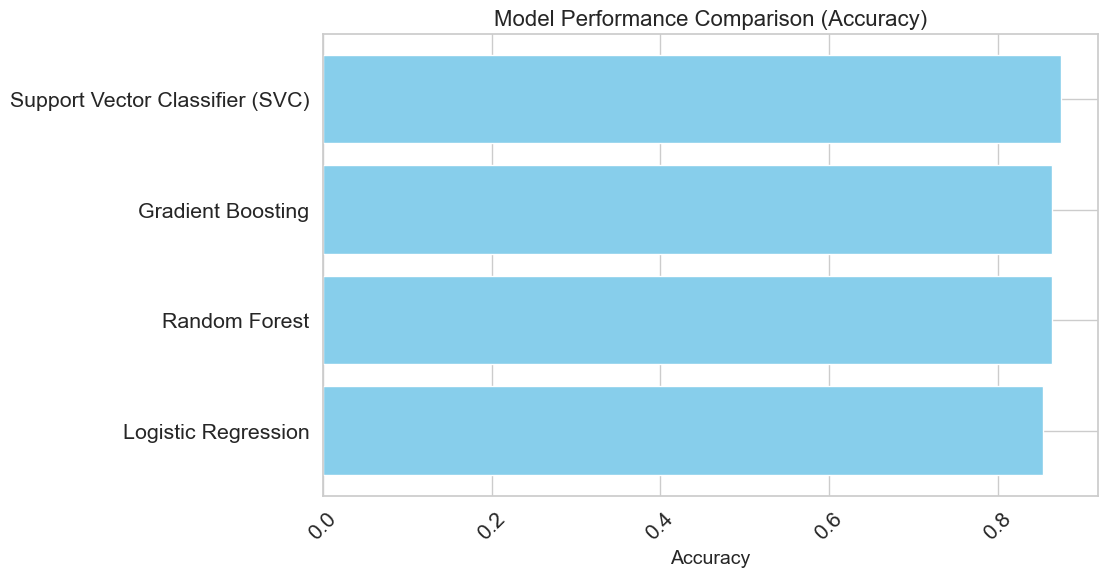

In [11]:

# Plot the ACC of each model
plt.figure(figsize=(10, 6))
plt.barh(list(results.keys()), list(results.values()), color='skyblue')
plt.xlabel('Accuracy', fontsize=14)   
plt.title('Model Performance Comparison (Accuracy)', fontsize=16) 
plt.xticks(rotation=45)
plt.show()


Based on test set evaluation using classification metrics, SVC is selected as the final model for predicting HeartDisease, achieving the highest overall accuracy and balanced classification performance across both classes.

### Confusion Matrix for SVC

A confusion matrix is plotted to visualize the classification performance of the SVC, showing the counts of true positives, true negatives, false positives, and false negatives.

<Figure size 600x600 with 0 Axes>

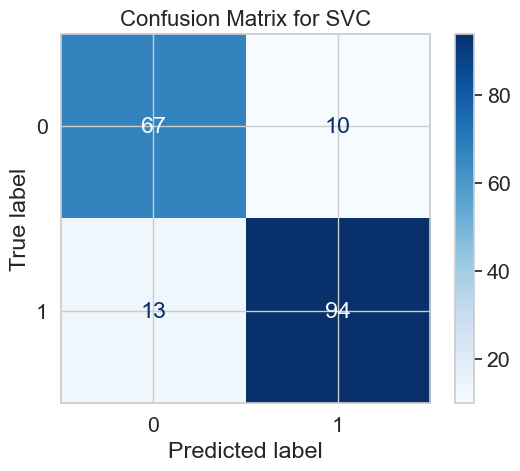

In [12]:

y_pred_svc = models['Support Vector Classifier (SVC)'].predict(X_test_scaled)

# Create and plot confusion matrix
cm = confusion_matrix(y_test, y_pred_svc)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for SVC', fontsize=16)
plt.show()

### ROC Curve for SVC

The ROC curve is plotted for the SVC to evaluate its ability to distinguish between classes. The AUC is also calculated to summarize model performance.

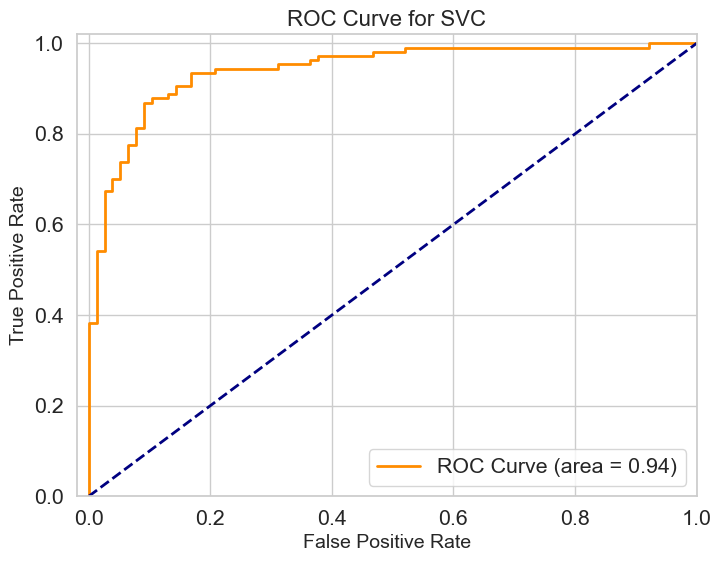

In [13]:

y_proba_svc = models['Support Vector Classifier (SVC)'].predict_proba(X_test_scaled)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba_svc)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve for SVC', fontsize=16)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

The Support Vector Classifier (SVC) achieved an accuracy of 87.5%, a confusion matrix showing strong sensitivity for detecting heart disease, and an outstanding ROC/AUC score of 0.94. These results demonstrate that the SVC model is highly effective for predicting heart disease based on the given dataset.

### Future Work

While the Support Vector Classifier achieved strong performance, future improvements could include exploring additional feature engineering techniques, balancing the dataset using methods like SMOTE to handle any potential class imbalance, and tuning hyperparameters more extensively across different models. Additionally, expanding the dataset with external health records or introducing more clinical features could potentially enhance prediction accuracy.